In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/gargsid/receipt_data_prediction_app/main/assets/data/ML_data_daily.csv

--2023-11-18 17:55:03--  https://raw.githubusercontent.com/gargsid/receipt_data_prediction_app/main/assets/data/ML_data_daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6981 (6.8K) [text/plain]
Saving to: ‘ML_data_daily.csv.1’

ML_data_daily.csv.1 100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-11-18 17:55:04 (73.4 MB/s) - ‘ML_data_daily.csv.1’ saved [6981/6981]



In [ ]:
def read_csv():
  df = pd.read_csv('ML_data_daily.csv')
  df['dates'] = pd.date_range(start='1/1/2021', end='31/12/2021', freq='D')
  new_df = df.groupby(pd.Grouper(key = 'dates', freq = 'M'))['Receipt_Count'].sum().reset_index()
  return new_df

### Data Analysis

<ipython-input-25-357b6cde460f>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['dates'] = pd.date_range(start='1/1/2021', end='31/12/2021', freq='D')


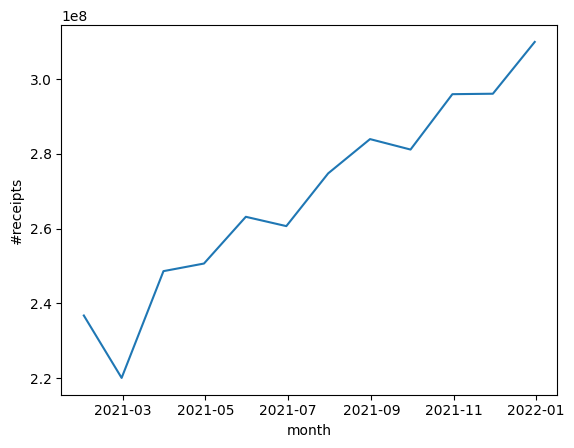

In [ ]:
df = read_csv()
plt.plot(df['dates'], df['Receipt_Count'])
plt.xlabel('month')
plt.ylabel('#receipts')
plt.show()

## Training MLP as a forecasting model.

We can see that receipts increase over the months and that increase is almost linear.
One trivial solution would be to fit a straight line and forecast the predictions on that line but that would be crude approximation. We can also use more sophisticated time series forecasting models like ARIMA that models non-linear trends in the model.

However, in this project we will write a light-weight neural network with a single hidden layer and ReLU non-linearity. The model will take sequence of inputs at a time regress the number of receipts for the next month.

We will see that the model is able to learn the non-linear increase in the data and continue to make very good predictions for the receipts over the months of year 2022.

**Let's dive in!**

First we will create an utility function that converts the given sequence of receipts into the training data where given the receipts over certain consecutive months we predict the receipts for the next month.

For example, if `receipts = [10,20,30,40]` and given a parameter `seq_len=2`, the training data will be

`Inputs: [[0,10],[10,20],[20,30]]`  

`Labels: [20,30,40]`

Note that we padded the first vector with 0 because our model expects inputs of same dimensions. The below function `split_sequence` takes care of creating the data in this format that is suitable for training the model.

In [ ]:
def split_sequence(sequence, n_steps, pad=False):
  X, y = list(), list()
  if pad:
    for i in range(n_steps-1, 0, -1):
      init = [0 for _ in range(n_steps)]
      for j in range(i, n_steps):
        init[j] = receipts[j-i]
      X.append(init)
      y.append(receipts[j-i+1])

  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return X, y

Next, we wrote a custom `Dataset` class that batches our training data nicely and allow seamless training.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ReceiptData(Dataset):
  def __init__(self, seq_receipts, labels, normalize_scale=1.):
    super().__init__()
    self.seq_receipts = np.array(seq_receipts) / normalize_scale
    self.labels = np.array(labels) / normalize_scale

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.seq_receipts[idx], self.labels[idx]

Now, we define our `Model` class that takes `seq_len` and `hidden` as inputs where the later is the size of the hidden layer in out single-layer MLP.

In [ ]:
def get_model(seq_len, hidden):
  model = nn.Sequential(
      nn.Linear(seq_len, hidden),
      nn.ReLU(),
      nn.Linear(hidden, hidden),
      nn.ReLU(),
      nn.Linear(hidden, 1)
  )
  return model


Here we load our training and validation data.

In [ ]:
def dataset_pipeline(seq_len, receipts):
  seq_receipts, labels = split_sequence(receipts, seq_len, pad)

  train_receipts, test_receipts = seq_receipts[:-3], seq_receipts[-3:]
  train_labels, test_labels = labels[:-3], labels[-3:]

  train_dataset = ReceiptData(train_receipts, train_labels, normalize)
  train_loader = DataLoader(train_dataset, batch_size=len(train_receipts))

  test_dataset = ReceiptData(test_receipts, test_labels, normalize)
  test_loader = DataLoader(test_dataset, batch_size=len(test_receipts))

  return train_loader, test_loader

The below function takes the sequence of receipts, and `seq_len` parameter and executes complete training pipeline where it creates traning and test datasets, and train a model to predict next month's receipt given a context length of size `seq_len`.

The trained model is saved as `model_seqlen_{seq_len}.pt`

In [ ]:
def receipt_predictor_pipeline(seq_len, receipts):
  train_loader, test_loader = dataset_pipeline(seq_len, receipts)

  model = get_model(seq_len, hidden)

  epochs = 10000
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,  weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=1e-6)
  save_model_name = f'model_seqlen_{seq_len}.pt'

  best_loss = 1e18
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss = 0.
    for inputs, labels in train_loader:
      inputs = inputs.to(torch.float)
      labels = labels.to(torch.float)
      preds = model(inputs)
      loss = criterion(labels, preds.view(-1))
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
      scheduler.step()

    model.eval()
    eval_loss = 0.
    for inputs, labels in test_loader:
      inputs = inputs.to(torch.float)
      labels = labels.to(torch.float)
      preds = model(inputs)
      loss = criterion(labels, preds.view(-1))

      eval_loss = loss.item()
      if eval_loss < best_loss:
        best_loss = eval_loss
        torch.save(model.state_dict(), save_model_name)
    if (epoch+1)%1000 == 0:
      print('epoch:', epoch+1, 'train:', train_loss, 'eval:', eval_loss)

  print('Evaluating Best Model....')
  model.load_state_dict(torch.load(save_model_name))
  model.eval()
  for inputs, labels in test_loader:
    inputs = inputs.to(torch.float)
    labels = labels.to(torch.float)
    preds = model(inputs)
  preds = preds.cpu().detach().numpy().squeeze()
  l = labels.cpu().detach().numpy().squeeze()
  error = ((preds - l)**2).mean()**0.5
  print('test_labels:',[ll for ll in l])
  print('preds:',[pred for pred in preds])
  print('rmse error:', error)

After training a bunch of models with different context length, we evaluate them against the evaluation data and choose the model that results in least Mean Square Error on the validation data. In our case, the `seq_len=2` gave the best results.

In [ ]:
def get_best_model(receipts):
  best_rmse = 1e8
  best_seq_len = None

  errors = []

  for seq_len in sequence_lengths:
    train_loader, test_loader = dataset_pipeline(seq_len, receipts)
    model = get_model(seq_len, hidden)

    save_model_name = f'model_seqlen_{seq_len}.pt'
    model.load_state_dict(torch.load(save_model_name))

    for inputs, labels in test_loader:
      inputs = inputs.to(torch.float)
      labels = labels.to(torch.float)
      preds = model(inputs)

    preds = preds.cpu().detach().numpy().squeeze()
    l = labels.cpu().detach().numpy().squeeze()
    error = ((preds - l)**2).mean()**0.5
    print('seq_len:', seq_len, 'rmse error:', error)
    errors.append(error)

    if error < best_rmse:
      best_rmse = error
      best_seq_len = seq_len

  plt.plot(sequence_lengths, errors)
  plt.xlabel('sequence_lengths')
  plt.ylabel('Validation RMSE values')
  plt.show()

  return best_seq_len


Below function is the final prediction or forecasting pipeline that uses the model with best results on the validation data and given the month_id as the input, it predicts the number of receipts over that month. The function uses a GPT style method where the predictions are fed back to the model that serve as contextual information and get the predictions over the successive months.

In [ ]:
def prediction_pipeline(month_id, seq_len, receipts):
  model = get_model(seq_len, hidden)
  save_model_name = f'model_seqlen_{seq_len}.pt'
  model.load_state_dict(torch.load(save_model_name))
  x = receipts[-seq_len:]
  for month in range(month_id):
    x = torch.from_numpy(np.array(x)).unsqueeze(0).to(torch.float)
    with torch.no_grad():
      pred = model(x)
    pred = pred.item()
    x = list(x[0].tolist())
    x = x[1:] + [pred]
    # print('month:', month+1, 'pred_receipts:', pred)

  return pred

In [ ]:
df = read_csv()
receipts = list(df['Receipt_Count'].values)
print('num_receipts:', len(receipts))

num_receipts: 12


<ipython-input-25-357b6cde460f>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['dates'] = pd.date_range(start='1/1/2021', end='31/12/2021', freq='D')


In [ ]:
# Hyperparameters
sequence_lengths = [2, 3, 4, 5, 6, 7, 8, 9]
hidden = 64
pad = True
normalize = 1e7

## Training the models

Below cell runs the training of multiple MLPs that uses different context length to make predictions.

In [ ]:
for seq_len in sequence_lengths:
  receipt_predictor_pipeline(seq_len, receipts)

epoch: 1000 train: 0.5596768856048584 eval: 0.21991439163684845
epoch: 2000 train: 0.5291222333908081 eval: 0.21100692451000214
epoch: 3000 train: 0.4867796003818512 eval: 0.17690414190292358
epoch: 4000 train: 0.4621063470840454 eval: 0.16200987994670868
epoch: 5000 train: 0.4298803210258484 eval: 0.1473381370306015
epoch: 6000 train: 0.3775922656059265 eval: 0.11566350609064102
epoch: 7000 train: 0.34112250804901123 eval: 0.09289932996034622
epoch: 8000 train: 0.317766010761261 eval: 0.0783451721072197
epoch: 9000 train: 0.302124947309494 eval: 0.07160943001508713
epoch: 10000 train: 0.2955324947834015 eval: 0.07012570649385452
Evaluating Best Model....
test_labels: [29.596518, 29.608517, 30.99487]
preds: [29.50113, 30.034956, 30.855486]
rmse error: 0.2648125874913323
epoch: 1000 train: 5.165093898773193 eval: 0.8040429949760437
epoch: 2000 train: 0.520712673664093 eval: 0.20651370286941528
epoch: 3000 train: 0.19818055629730225 eval: 0.14466534554958344
epoch: 4000 train: 0.18328955

After training, we evaluate the models on the validation data and choose the model with least root mean square error.

seq_len: 2 rmse error: 0.2648125874913323
seq_len: 3 rmse error: 0.3332681505228367
seq_len: 4 rmse error: 0.3148573652404641
seq_len: 5 rmse error: 0.332759496112688
seq_len: 6 rmse error: 0.30829106950854573
seq_len: 7 rmse error: 0.35669101973234635
seq_len: 8 rmse error: 0.38062185070069177
seq_len: 9 rmse error: 0.4247839210082217


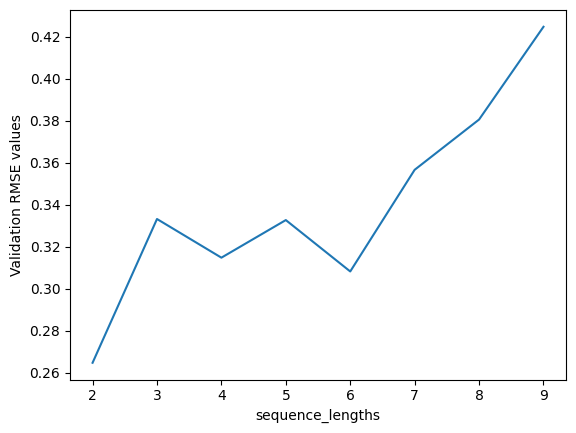

best_seq_len: 2


In [ ]:
best_seq_len = get_best_model(receipts)
print('best_seq_len:', best_seq_len)

## Making Predictions!

Now that we have our best model, we can use it to predict the receipts for the year 2022 using the below cell.

In [ ]:
months = [i for i in range(1, 13)]
for m in months:
  receipt_pred = prediction_pipeline(m, best_seq_len, receipts)
  print('month:', m, 'receipts:', receipt_pred)

month: 1 receipts: 311809568.0
month: 2 receipts: 318207584.0
month: 3 receipts: 322898336.0
month: 4 receipts: 328325376.0
month: 5 receipts: 333600128.0
month: 6 receipts: 339048320.0
month: 7 receipts: 344553152.0
month: 8 receipts: 350159168.0
month: 9 receipts: 355852096.0
month: 10 receipts: 361639168.0
month: 11 receipts: 367519744.0
month: 12 receipts: 373496160.0


## Concluding Remarks

In this notebook, we showed how to model sequential receipt data for the year 2021 and forecast the number of receipts over the year 2022. We used a single-layer neural network for this task and saw that the model was able to replicate the increasing trend in its predictions.



**What didn't work**: Given the nature of the problem of learning from sequential receipt data, I also implemented a light-weight Transformer network to see whether it replicates or outperforms the single layer MLP. However, we saw that the model just output the same prediction for every input that minimizes the mean square error.

This might be because of very less amount of training data and the model is not able to learn the increasing trend. To see in more detail please carry on with the walkthrough.

In [ ]:
import torch
import torch.nn as nn
from typing import Any, Optional, Tuple, Union
import torch.nn.functional as F
import numpy as np
import pandas as pd

class QuickGELU(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(1.702 * x)
class MHAttention(nn.Module):
    def __init__(self, d_model, num_heads, attn_mask=None):
      super().__init__()
      self.d_model = d_model # d_model/n_heads = 64 (head_dim) from "Attention is all you need"
      self.num_heads = num_heads
      self.head_dim = d_model // num_heads

      # D = 64 * num_heads
      # d = 64
      # h = num_heads
      # L = seq_len

      if self.head_dim * self.num_heads != self.d_model:
        raise ValueError(
            f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.d_model} and `num_heads`:"
            f" {self.num_heads})."
        )

      self.scale = self.head_dim**-0.5 # sqrt(512/8=64)
      self.dropout = 0.1

      self.q_proj = nn.Linear(d_model, d_model)
      self.k_proj = nn.Linear(d_model, d_model)
      self.v_proj = nn.Linear(d_model, d_model)

      self.out_proj = nn.Linear(d_model, d_model) # first d_model = d_v * n_heads

    def _shape(self, tensor, seq_len, bsz):
      # return N,h,L,d tensor
      return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1,2).contiguous()

    def forward(self, x, attn_mask=None, output_attentions=True): # NLD

      # attn_mask : size()-> (bsz, 1, L, L)

      bsz, ctx_len, embed_dim = x.size()

      queries = self.q_proj(x) * self.scale # NLD

      keys = self.k_proj(x) # NLD
      keys = self._shape(keys, -1, bsz) # NhLd

      values = self.v_proj(x)
      values = self._shape(values, -1, bsz) # NhLd

      proj_shape = (bsz * self.num_heads, -1, self.head_dim)

      queries = self._shape(queries, ctx_len, bsz).view(*proj_shape) # N*h, L, d
      keys = keys.view(*proj_shape) # N*h, L, d
      values = values.view(*proj_shape) # N*h, L, d

      src_len = keys.size(1)

      # keys.transpose(1,2) # N*h, d, L
      attn_weights = torch.bmm(queries, keys.transpose(1,2)) # N*h, L, L

      if attn_mask is not None:
        # adds -inf to values where we don't want to put attention to
        attn_weights = attn_weights.view(bsz, self.num_heads, ctx_len, ctx_len) + attn_mask
        attn_weights = attn_weights.view(bsz * self.num_heads, ctx_len, ctx_len) # N*h, L, L

      attn_weights = nn.functional.softmax(attn_weights, dim=-1) # softmax(-inf) -> 0 -> attention is zero for that token

      if output_attentions:
        # From CLIP's repo: this operation is a bit akward, but it's required to
        # make sure that attn_weights keeps its gradient.
        # In order to do so, attn_weights have to reshaped
        # twice and have to be reused in the following
        attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, ctx_len, ctx_len)
        attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, ctx_len, ctx_len)
      else:
        attn_weights_reshaped = None

      # N*h, L, L
      attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

      # values: N*h, L, d
      attn_outputs = torch.bmm(attn_probs, values) # N*h, L, d

      attn_outputs = attn_outputs.contiguous().view(bsz, self.num_heads, ctx_len, self.head_dim)
      attn_outputs = attn_outputs.transpose(1,2)
      attn_outputs = attn_outputs.contiguous().view(bsz, ctx_len, self.d_model)

      attn_outputs = self.out_proj(attn_outputs)
      return attn_outputs, attn_weights_reshaped

class ResidualAttentionBlock(nn.Module):
  def __init__(self, d_model, n_heads, attn_mask=None):
    super().__init__()

    self.attn_block = MHAttention(d_model, n_heads, attn_mask)
    self.ln_1 = nn.LayerNorm(d_model)
    self.mlp = nn.Sequential(
        nn.Linear(d_model, 4*d_model),
        QuickGELU(),
        nn.Linear(4*d_model, d_model)
    )
    self.ln_2 = nn.LayerNorm(d_model)
    self.attn_mask = attn_mask

  def attention(self, x):
    self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
    return self.attn_block(x, attn_mask=self.attn_mask, output_attentions=False)[0]

  def forward(self, x): # NLD
    res = x
    x = self.ln_1(x)
    x = self.attention(x)
    x += res
    res = x
    x = self.ln_2(x)
    x = self.mlp(x)
    x += res
    return x

class Transformer(nn.Module):
  def __init__(self,
               width,
               layers,
               heads,
               attn_mask=None,
               ):
    super().__init__()

    self.model = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask=attn_mask) for _ in range(layers)])

  def forward(self, x): # x: NLD
    return self.model(x)

def build_causal_attn_mask(ctx_len):
  mask = torch.empty(ctx_len, ctx_len)
  mask.fill_(float('-inf'))
  mask.triu_(1)
  return mask


In [ ]:
import torch
import torch.nn as nn
# from transformers import Transformer

def build_causal_attn_mask(ctx_len):
  mask = torch.empty(ctx_len, ctx_len)
  mask.fill_(float('-inf'))
  mask.triu_(1)
  return mask

class ReceiptTransformer(nn.Module):
  def __init__(self, d_model, layers, num_heads, attn_mask=None):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.layers = layers
    self.attn_mask = attn_mask

    self.month_embedding = nn.Embedding(12, d_model) # vocab_size=12
    self.receipt_embedding = nn.Linear(1, d_model) # input_dim=1
    self.cls_embed = nn.Parameter(torch.randn(d_model))
    self.transformer = Transformer(d_model, layers, num_heads, attn_mask)
    self.ln_post = nn.LayerNorm(self.d_model)
    self.proj = nn.Parameter(torch.randn(d_model, 1))


  def forward(self, inputs):
    # months: torch.tensor -> [[m1, m2, m3], [m2,m3,m4]] bsz, seq
    # receipts: torch.tensor -> [[r1, r2, r3], [r2,r3,r4]]  bsz, seq
    bsz = months.shape[0]
    seq = months.shape[1]
    month_x = self.month_embedding(months) # bsz, seq, d_model
    # print('month_x:', month_x.shape)
    receipt_x = self.receipt_embedding(receipts.view(-1, 1)) # bsz * seq, d_model,
    # print('receipt_x:', receipt_x.shape)
    receipt_x = receipt_x.view(bsz, seq, -1)
    x = month_x + receipt_x # bsz, seq, d_model
    cls_tokens = torch.cat(bsz * [self.cls_embed]).view(bsz, 1, -1) # bsz, 1, d_model
    x = torch.cat([cls_tokens, x], dim=1) # bsz, seq+1, d_model
    # print('transformer input:', x.shape)
    x = self.transformer(x)
    x = self.ln_post(x[:, 0, :]) # # bsz, d_model
    x = x @ self.proj
    return x


In [ ]:
ctx_len = 3
d_model = 64
layers = 2
num_heads = 1
mask = build_causal_attn_mask(ctx_len+1)

model = ReceiptTransformer(d_model, layers, num_heads, mask)

In [ ]:
# data loaders
train_loader, test_loader = dataset_pipeline(ctx_len, receipts)

In [ ]:
criterion = nn.MSELoss()
epochs = 2000
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
print('device:', device)

model.to(device).to(torch.double)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,  weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=1e-6)

x = []
t = []
e = []

for epoch in range(epochs):
  model.train()
  x += [epoch]
  optimizer.zero_grad()
  train_loss = 0.
  for inputs, labels in train_loader:
    inputs = receipts.to(device)
    labels = labels.to(device)
    preds = model(months, inputs.to(torch.double))
    loss = criterion(labels, preds.view(-1))
    train_loss += loss.item()
    # print('epoch:', epoch, 'train_loss:', loss.item())
    loss.backward()
    optimizer.step()
  # t += [loss.item()]

  model.eval()
  for months, receipts, labels in test_loader:
    months = months.to(device)
    receipts = receipts.to(device)
    labels = labels.to(device)
    preds = model(months, receipts)
    loss = criterion(labels, preds.view(-1))
    print('epoch:', epoch, 'train:', train_loss, 'eval:', loss.item())
  # e += [loss.item()]
  # plt.plot(x, t)
  # plt.plot(x, e)
  # plt.show()


device: cpu


ValueError: ignored

In [ ]:
for months, receipts, labels in test_loader:
  months = months.to(device)
  receipts = receipts.to(device)
  labels = labels.to(device)
  preds = model(months, receipts)

print(labels)
print(preds)